# Rule only

Evaluation in the case of a decision-making system based only on input attributes.
Results obtained with SMACE are compared to those obtained by applying LIME and SHAP on the whole decision system.

In [1]:
import json
import numpy as np
import pandas as pd
import warnings
import shap
import lime.lime_tabular
import sys
from anchor import anchor_tabular
import os

warnings.filterwarnings("ignore")
np.random.seed(seed=1)

In [2]:
# path here
path = os.getcwd().replace(os.path.join("evaluation", "notebooks"), "")
sys.path.append(path)

In [3]:
from smace.rules import Rule
from smace.decisions import DM
from smace.explainer import Smace
from smace import utils

The input data is a random sample of three uniform variables $x_1$, $x_2$ and $x_3$ in $[0,1]$.

In [4]:
# input data
data = np.random.rand(1000, 3)
df = pd.DataFrame(data, columns=["x1", "x2", "x3"])
df.head()

,x1,x2,x3
0,0.417022,0.720324,0.000114
1,0.302333,0.146756,0.092339
2,0.186260,0.345561,0.396767
3,0.538817,0.419195,0.685220
4,0.204452,0.878117,0.027388


In [5]:
# decision rules
with open("rule_simple.json", "r") as fp:
    rules_json = json.load(fp)

In [6]:
# decision system
dm = DM(rules_json, [], df)  # model_list = []

In [7]:
# Initialize the explainers
explainer = Smace(dm)
data_summary = shap.sample(df, 100)
shap_explainer = shap.KernelExplainer(dm.make_decision_eval, data_summary)
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    df.values,
    feature_names=df.columns,
    discretize_continuous=True,
    verbose=False,
    mode="classification",
)

The rule only refers to features. There are no models.

In [8]:
dm.rules["simple"].labels

['x1 <= 0.5', 'x2 >= 0.6', 'x3 >= 0.2']

### Generic example
Let us pick a random example in our dataset.

In [9]:
# example = np.array(df.loc[1])
example = np.array([0.6, 0.1, 0.4])
print(example)

[0.6 0.1 0.4]


The example does not satisfies all the condition, so it is classified as $0$.

We want to know the contribution of the three variables to that decision.

In [10]:
shap_explainer.shap_values(example)

array([-0.07833333, -0.07833333,  0.01666667])

In [11]:
e = explainer.explain(example, "simple").exp
shap_values = shap_explainer.shap_values(example)
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res["SMACE"] = list(e.values())
res["SHAP"] = np.round(shap_values, 3)
res["LIME"] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.900,-0.078,-0.212
x2,-0.499,-0.078,-0.211
x3,0.800,0.017,0.075


<AxesSubplot:>

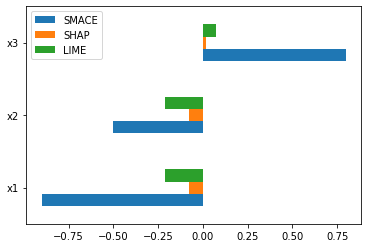

In [12]:
res.plot.barh()

In [13]:
# Anchors
print("Anchors")
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print("Anchor: %s" % (" AND ".join(exp.names())))
print("Precision: %.2f" % exp.precision())
print("Coverage: %.2f" % exp.coverage())

Anchors
Anchor: x2 <= 0.52
Precision: 1.00
Coverage: 0.50


### Example on the decision boundary
Now we consider an example exactly on the decision boundary, where the sensitivity is maximum.

In [14]:
example = np.array([0.5, 0.6, 0.25])
print(example)

[0.5  0.6  0.25]


The example satisfies all the conditions.

In [15]:
e = explainer.explain(example, "simple").exp
shap_values = shap_explainer.shap_values(example)[0]
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res["SMACE"] = list(e.values())
res["SHAP"] = np.round(shap_values, 3)
res["LIME"] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,1.00,0.37,-0.215
x2,1.00,0.37,0.123
x3,0.95,0.37,-0.173


<AxesSubplot:>

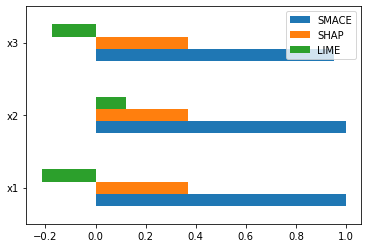

In [16]:
res.plot.barh()

In [17]:
# Anchors
print("Anchors")
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print("Anchor: %s" % (" AND ".join(exp.names())))
print("Precision: %.2f" % exp.precision())
print("Coverage: %.2f" % exp.coverage())

Anchors
Anchor: x2 > 0.52 AND x1 <= 0.75
Precision: 0.44
Coverage: 0.37


### Slight violation on one attribute
Example with slight violation on $x_1$

In [18]:
example = np.array([0.51, 0.6, 0.2])
print(example)

[0.51 0.6  0.2 ]


In [19]:
e = explainer.explain(example, "simple").exp
shap_values = shap_explainer.shap_values(example)
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res["SMACE"] = list(e.values())
res["SHAP"] = np.round(shap_values, 3)
res["LIME"] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.99,-0.293,-0.221
x2,1.00,0.122,0.142
x3,1.00,0.032,-0.196


<AxesSubplot:>

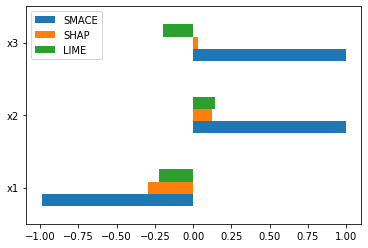

In [20]:
res.plot.barh()

In [21]:
# Anchors
print("Anchors")
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print("Anchor: %s" % (" AND ".join(exp.names())))
print("Precision: %.2f" % exp.precision())
print("Coverage: %.2f" % exp.coverage())

Anchors
Anchor: x1 > 0.49
Precision: 0.99
Coverage: 0.49


### Violation on two attributes
Let us now analyze the case where the rules on two variables are violated. 
This means that in order to bring the result into $1$ it is necessary to move two variables simultaneously.

In [22]:
example = np.array([0.6, 0.1, 0.8])
print(example)

[0.6 0.1 0.8]


In [23]:
e = explainer.explain(example, "simple").exp
shap_values = shap_explainer.shap_values(example)
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res["SMACE"] = list(e.values())
res["SHAP"] = np.round(shap_values, 3)
res["LIME"] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.900,-0.078,-0.200
x2,-0.499,-0.078,-0.208
x3,0.400,0.017,0.058


<AxesSubplot:>

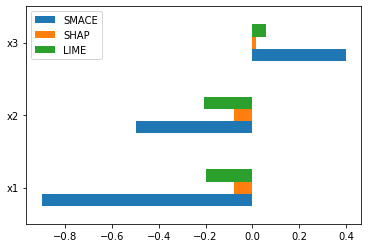

In [24]:
res.plot.barh()

In [25]:
# Anchors
print("Anchors")
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print("Anchor: %s" % (" AND ".join(exp.names())))
print("Precision: %.2f" % exp.precision())
print("Coverage: %.2f" % exp.coverage())

Anchors
Anchor: x2 <= 0.52
Precision: 1.00
Coverage: 0.51


### Violation on each attribute

In [26]:
example = np.array([0.65, 0.59, 0.14])
print(example)

[0.65 0.59 0.14]


In [27]:
e = explainer.explain(example, "simple").exp
shap_values = shap_explainer.shap_values(example)
exp = lime_explainer.explain_instance(example, dm.make_decision_class)
lime_values = utils.lime_mapper(exp)
res = pd.DataFrame(index=list(e.keys()))
res["SMACE"] = list(e.values())
res["SHAP"] = np.round(shap_values, 3)
res["LIME"] = np.round(lime_values, 3)
res

,SMACE,SHAP,LIME
x1,-0.85,-0.047,-0.220
x2,-0.99,-0.047,0.139
x3,-0.94,-0.047,-0.193


<AxesSubplot:>

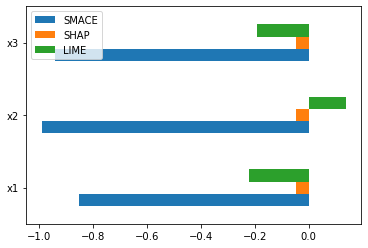

In [28]:
res.plot.barh()

In [29]:
# Anchors
print("Anchors")
anchors_exp = anchor_tabular.AnchorTabularExplainer([0, 1], df.columns, df.values)
exp = anchors_exp.explain_instance(example, dm.make_decision_eval, threshold=0.95)
print("Anchor: %s" % (" AND ".join(exp.names())))
print("Precision: %.2f" % exp.precision())
print("Coverage: %.2f" % exp.coverage())

Anchors
Anchor: x1 > 0.49
Precision: 1.00
Coverage: 0.49
